# Introduccion

- En este proyecto necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

1. Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba.
2. Además, debes medir la métrica AUC-ROC y compararla con el valor F1.
3. Examina el equilibrio de clases. Entrena el modelo sin tener en cuenta el desequilibrio. Describe brevemente tus hallazgos.
4. Mejora la calidad del modelo. Asegúrate de utilizar al menos dos enfoques para corregir el desequilibrio de clases. Utiliza conjuntos de entrenamiento y validación para encontrar el mejor modelo y el mejor conjunto de parámetros. Entrena diferentes modelos en los conjuntos de entrenamiento y validación. Encuentra el mejor. Describe brevemente tus hallazgos.
5. Realiza la prueba final.

# Contenido
* [1. Introducción]
* [2. Contenidos]
* [3. Inicialización]
    * [3.1 Cargar las librerias]
    * [3.2 Cargar los datos]
* [4. Segmentación de datos]
    * [4.1 Generacion del modelo]
    * [4.2 Creacion del arbol de decision]
* [5. Conclusiones]

# Inicializacion

## Cargar las librerias

In [ ]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, r2_score, roc_auc_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

## Cargar los datos

In [ ]:
data = pd.read_csv('/datasets/Churn.csv')

In [ ]:
display(data.shape)
display(data.info())
display(data.head())

(10000, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


- Podemos observar que nos encontramos con algunos valores faltantes en la columna Tenure en la cual decidí imputar con el promedio general de la columna, en un escenario real preguntaria a mis superiores para saber la causa raiz de los valores faltantes.

## Imputar datos faltantes

In [ ]:
# Imputar con la media y cambiar la columna a int
mean = np.ceil(data['Tenure'].mean())
data['Tenure'] = data['Tenure'].fillna(mean)

In [ ]:
data['Tenure'] = data['Tenure'].astype('int64')

# Segmentacion y generacion de modelos

In [ ]:
data = data.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


None

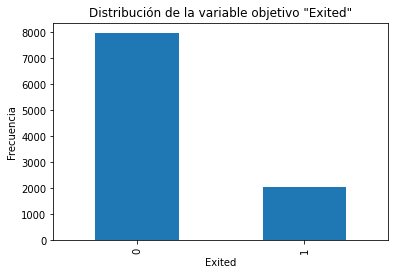

In [ ]:
# Examina el equilibrio de clases. Entrena el modelo sin tener en cuenta el desequilibrio
data['Exited'].value_counts().plot(kind='bar')
plt.title('Distribución de la variable objetivo "Exited"')
plt.xlabel('Exited')
plt.ylabel('Frecuencia')
plt.show()

- Con este diagrama de barras podemos examinar el equilibrio de clases para la variable objetivo "Exited" la cual nos indica que la probabilidad de que un cliente salga del banco sin tomar en cuenta el desequilibrio, con estos datos se procedera a entrenar un modelo de regresion logistica.

In [ ]:
# Se aplica OHE a las columnas "Geography" y "Gender" y se elimina la columna original Geography
data = pd.get_dummies(data, columns=['Gender'], drop_first=True)
geo_dummies = pd.get_dummies(data['Geography'], prefix='geo')
data = pd.concat([data, geo_dummies], axis=1)
data.drop('Geography', axis=1, inplace=True)

In [ ]:
# Segmentamos el dataframe en 3 partes, el conjunto de entrenamiento corresponde al 60% de los datos, el de prueba al 20% y el de validación al 20%
data_train, data_test = train_test_split(data, test_size=0.20, random_state=54321)
data_train, data_valid = train_test_split(data_train, test_size=0.25, random_state=54321)

In [ ]:
# Se declaran caracteristicas y objetivos para los diferentes conjuntos de datos
features_train = data_train.drop(['Exited'], axis=1)
target_train = data_train['Exited']
features_valid = data_valid.drop(['Exited'], axis=1)
target_valid = data_valid['Exited']
features_test = data_test.drop(['Exited'], axis=1)
target_test = data_test['Exited']

## Regresion logistica

In [ ]:
# Crear un modelo de regresión logística
model = LogisticRegression(random_state = 54321, solver='liblinear')
model.fit(features_train, target_train)
target_prediction = model.predict(features_test)

# Calcular la precisión del modelo
score_train = model.score(features_train, target_train)

print("Accuracy del modelo de regresión logística en el conjunto de entrenamiento:", score_train)

Accuracy del modelo de regresión logística en el conjunto de entrenamiento: 0.7956666666666666


- Aqui podemos observar que el modelo sin ajustar con una regresion logistcia tiene un 79% de precision.

## Bosque aleatorio

In [ ]:
# Bosque aleatorio de decisión conjunto de entrenamiento
best_score = 0
best_est = 0
for est in range(1, 51, 10): # selecciona el rango del hiperparámetro
    model = RandomForestClassifier(random_state=54321, n_estimators=est, min_samples_split=2)
    model.fit(features_train, target_train)
    score = model.score(features_valid, target_valid)
    if score > best_score:
        best_score = score
        best_est = est

print("Accuracy del mejor modelo en el conjunto de validacion (n_estimators = {}): {}".format(best_est, best_score))

Accuracy del mejor modelo en el conjunto de validacion (n_estimators = 41): 0.8445


- Aqui con este modelo de bosque aleatorio dimos con una exactitud del 84% para el conjunto de entrenamiento en el estimador 41.

## Arbol de decision

In [ ]:
# Arbol de decisión conjunto de entrenamiento
best_tree = 0
best_depth = 0
score_one = 0
for depth in range(1, 51): # selecciona el rango del hiperparámetro
    tree = DecisionTreeClassifier(random_state=54321, max_depth = depth,  min_samples_leaf=1)
    tree.fit(features_train, target_train)
    score_one = tree.score(features_valid, target_valid)
    if score_one > best_tree:
        best_tree = score_one
        best_depth = depth

print("Accuracy del mejor modelo en el conjunto de validación (depth = {}): {}".format(best_depth, best_tree))

Accuracy del mejor modelo en el conjunto de validación (depth = 6): 0.8495


- Para este arbol de decision el mejor modelo es con una profundidad de 6 y nos da una exactitud del 85%.

# Sobremuestreo

## Conjunto de validacion

In [ ]:
# Se define la funcion upsample para corregir el sobremuestreo para el conjunto de validacion con regresion logistica
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=54321
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 10
)

model_one = LogisticRegression(random_state=54321, solver='liblinear')
model_one.fit(features_upsampled, target_upsampled)
predicted_valid = model_one.predict(features_valid)
probabilities_valid = model_one.predict_proba(features_valid)[:, 1]

print('F1 con sobremuestreo para el conjunto de validacion:', f1_score(target_valid, predicted_valid))
print('AUC-ROC con sobremuestreo para el conjunto de validacion:', roc_auc_score(target_valid, probabilities_valid))

F1 con sobremuestreo para el conjunto de validacion: 0.38120805369127514
AUC-ROC con sobremuestreo para el conjunto de validacion: 0.73956052254021


In [ ]:
# Bosque aleatorio para el conjunto de validacion con sobremuestreo
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

for est in range(1, 51, 10): # selecciona el rango del hiperparámetro
    model_two = RandomForestClassifier(random_state=54321, n_estimators=est)
    model_two.fit(features_upsampled, target_upsampled)
    score = model_two.score(features_valid, target_valid)
    if score > best_score:
        best_score = score
        best_est = est

predicted_valid_two = model_two.predict(features_valid)
probabilities_valid_two = model_two.predict_proba(features_valid)[:, 1]

print("Accuracy del mejor modelo en el conjunto de validacion (n_estimators = {}): {}".format(best_est, best_score))
print('F1 con sobremuestreo para el conjunto de validacion:', f1_score(target_valid, predicted_valid_two))
print('AUC-ROC con sobremuestreo para el conjunto de validacion:', roc_auc_score(target_valid, probabilities_valid_two))

Accuracy del mejor modelo en el conjunto de validacion (n_estimators = 41): 0.8445
F1 con sobremuestreo para el conjunto de validacion: 0.5865030674846625
AUC-ROC con sobremuestreo para el conjunto de validacion: 0.837069220894638


In [ ]:
# Arbol de decision para el conjunto de validacion con sobremuestreo
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

for depth in range(1, 51): # selecciona el rango del hiperparámetro
    model_three = DecisionTreeClassifier(random_state=54321, max_depth = depth,  min_samples_leaf=1)
    model_three.fit(features_upsampled, target_upsampled)
    score_one = model_three.score(features_valid, target_valid)
    if score_one > best_tree:
        best_tree = score_one
        best_depth = depth

predicted_valid_three = model_three.predict(features_valid)
probabilities_valid_three = model_three.predict_proba(features_valid)[:, 1]

print("Accuracy del mejor modelo en el conjunto de validación (depth = {}): {}".format(best_depth, best_tree))
print('F1 con sobremuestreo para el conjunto de validacion:', f1_score(target_valid, predicted_valid_three))
print('AUC-ROC con sobremuestreo para el conjunto de validacion:', roc_auc_score(target_valid, probabilities_valid_three))

Accuracy del mejor modelo en el conjunto de validación (depth = 6): 0.8495
F1 con sobremuestreo para el conjunto de validacion: 0.5214285714285715
AUC-ROC con sobremuestreo para el conjunto de validacion: 0.6902921136856046


- Tras haber realizado una prueba de f1 con sobremuestreo podemos observar que el mejor score para f1 es con un bosque aleatorio dandonos un f1 de 0.58 y un AUC-ROC de 0.83.

## Conjunto de entrenamiento

In [ ]:
# Se prueba con el sobremuestreo para el conjunto de entrenamiento con una regresion logistica
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

model_train = LogisticRegression(random_state=54321, solver='liblinear')
model_train.fit(features_upsampled, target_upsampled)
predicted_train = model_train.predict(features_train)
probabilities_train = model_train.predict_proba(features_train)[:, 1]

print('F1 con sobremuestreo para el conjunto de entrenamiento:', f1_score(target_train, predicted_train))
print('AUC-ROC con sobremuestreo para el conjunto de entrenamiento:', roc_auc_score(target_train, probabilities_train))

F1 con sobremuestreo para el conjunto de entrenamiento: 0.36005539313740575
AUC-ROC con sobremuestreo para el conjunto de entrenamiento: 0.7159570610810881


In [ ]:
# Bosque aleatorio para el conjunto de entrenamiento
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

for est in range(1, 51, 10): # selecciona el rango del hiperparámetro
    model_train_two = RandomForestClassifier(random_state=54321, n_estimators=est)
    model_train_two.fit(features_upsampled, target_upsampled)
    score = model_train_two.score(features_valid, target_valid)
    if score > best_score:
        best_score = score
        best_est = est

predicted_train_two = model_train_two.predict(features_train)
probabilities_train_two = model_train_two.predict_proba(features_train)[:, 1]

print("Accuracy del mejor modelo en el conjunto de entrenamiento (n_estimators = {}): {}".format(best_est, best_score))
print('F1 con sobremuestreo para el conjunto de entrenamiento:', f1_score(target_train, predicted_train_two))
print('AUC-ROC con sobremuestreo para el conjunto de entrenamiento:', roc_auc_score(target_train, probabilities_train_two))

Accuracy del mejor modelo en el conjunto de entrenamiento (n_estimators = 41): 0.8445
F1 con sobremuestreo para el conjunto de entrenamiento: 0.9995852343425965
AUC-ROC con sobremuestreo para el conjunto de entrenamiento: 1.0


In [ ]:
# Arbol de decision para el conjunto de entrenamiento
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

for depth in range(1, 51): # selecciona el rango del hiperparámetro
    model_train_three = DecisionTreeClassifier(random_state=54321, max_depth = depth,  min_samples_leaf=1)
    model_train_three.fit(features_upsampled, target_upsampled)
    score_one = model_train_three.score(features_valid, target_valid)
    if score_one > best_tree:
        best_tree = score_one
        best_depth = depth

predicted_train_three = model_train_three.predict(features_train)
probabilities_train_three = model_train_three.predict_proba(features_train)[:, 1]

print("Accuracy del mejor modelo en el conjunto de entrenamiento (depth = {}): {}".format(best_depth, best_tree))
print('F1 con sobremuestreo para el conjunto de entrenamiento:', f1_score(target_train, predicted_train_three))
print('AUC-ROC con sobremuestreo para el conjunto de entrenamiento:', roc_auc_score(target_train, probabilities_train_three))

Accuracy del mejor modelo en el conjunto de entrenamiento (depth = 6): 0.8495
F1 con sobremuestreo para el conjunto de entrenamiento: 1.0
AUC-ROC con sobremuestreo para el conjunto de entrenamiento: 1.0


- De momento tras entrenar estos modelos con un sobreajuste podemos observar que el f1 para el conjunto de entrenamiento es de 33% y para el conjunto de validacion es de 36%. Y que el bosque aleatorio para el conjunto de validacion con sobreajuste nos da un f1 score de 0.5632. De igual manera podemos ver que para el bosque aleatorio para el conjunto de entrenamiento nos da un valor de 99.95% de f1.

# Submuestreo

## Conjunto de validacion

In [ ]:
# Se define la funcion downsample para corregir el submuestreo para el conjunto de validacion
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=54321)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=54321)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=54321
    )

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.1
)

model_sub = LogisticRegression(random_state=54321, solver='liblinear')
model_sub.fit(features_downsampled, target_downsampled)
predicted_valid_sub = model_sub.predict(features_valid)
probabilities_valid_sub = model_sub.predict_proba(features_valid)[:, 1]

print("Accuracy del mejor modelo en el conjunto de validacion (n_estimators = {}): {}".format(best_est, best_score))
print('F1 con submuestreo para el conjunto de validacion:', f1_score(target_valid, predicted_valid_sub))
print('AUC-ROC con submuestreo para el conjunto de validacion:', roc_auc_score(target_valid, probabilities_valid_sub))

Accuracy del mejor modelo en el conjunto de validacion (n_estimators = 41): 0.8445
F1 con submuestreo para el conjunto de validacion: 0.37775816416593117
AUC-ROC con submuestreo para el conjunto de validacion: 0.7393470570809542


In [ ]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

for est in range(1, 51, 10): # selecciona el rango del hiperparámetro
    model_sub_two = RandomForestClassifier(random_state=54321, n_estimators=est)
    model_sub_two.fit(features_upsampled, target_upsampled)
    score = model_sub_two.score(features_valid, target_valid)
    if score > best_score:
        best_score = score
        best_est = est

predicted_valid_sub_two = model_sub_two.predict(features_valid)
probabilities_valid_sub_two = model_sub_two.predict_proba(features_valid)[:, 1]

print("Accuracy del mejor modelo en el conjunto de validacion (n_estimators = {}): {}".format(best_est, best_score))
print('F1 con submuestreo para el conjunto de validacion:', f1_score(target_valid, predicted_valid_sub_two))
print('AUC-ROC con submuestreo para el conjunto de validacion:', roc_auc_score(target_valid, probabilities_valid_sub_two))

Accuracy del mejor modelo en el conjunto de validacion (n_estimators = 41): 0.8445
F1 con submuestreo para el conjunto de validacion: 0.5865030674846625
AUC-ROC con submuestreo para el conjunto de validacion: 0.837069220894638


In [ ]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

for depth in range(1, 51): # selecciona el rango del hiperparámetro
    model_sub_three = DecisionTreeClassifier(random_state=54321, max_depth = depth,  min_samples_leaf=1)
    model_sub_three.fit(features_upsampled, target_upsampled)
    score_one = model_sub_three.score(features_valid, target_valid)
    if score_one > best_tree:
        best_tree = score_one
        best_depth = depth

predicted_valid_sub_three = model_sub_three.predict(features_valid)
probabilities_valid_sub_three = model_sub_three.predict_proba(features_valid)[:, 1]

print("Accuracy del mejor modelo en el conjunto de validación (depth = {}): {}".format(best_depth, best_tree))
print('F1 con submuestreo para el conjunto de validacion:', f1_score(target_valid, predicted_valid_sub_three))
print('AUC-ROC con submuestreo para el conjunto de validacion:', roc_auc_score(target_valid, probabilities_valid_sub_three))

Accuracy del mejor modelo en el conjunto de validación (depth = 6): 0.8495
F1 con submuestreo para el conjunto de validacion: 0.5214285714285715
AUC-ROC con submuestreo para el conjunto de validacion: 0.6902921136856046


- Para el submuestreo y el conjunto de validacion el mejor modelo fue bosque aleatorio que nos arroja un valor f1 de 0.58 y un valor de AUC-ROC de 0.83.

## Conjunto de entrenamiento

In [ ]:
# Se define la funcion downsample para corregir el submuestreo para el conjunto de entrenamiento
features_downsampled, target_downsampled = downsample(features_valid, target_valid, 0.1)

model_sub_train = LogisticRegression(random_state=54321, solver='liblinear')
model_sub_train.fit(features_downsampled, target_downsampled)
predicted_train_sub = model_sub_train.predict(features_train)
probabilities_train_sub = model_sub_train.predict_proba(features_train)[:, 1]

print('F1 con submuestreo para el conjunto de entrenamiento:', f1_score(target_train, predicted_train_sub))
print('AUC-ROC con submuestreo para el conjunto de validacion:', roc_auc_score(target_train, probabilities_train_sub))

F1 con submuestreo para el conjunto de entrenamiento: 0.35644162513215527
AUC-ROC con submuestreo para el conjunto de validacion: 0.7159560226549959


In [ ]:
features_downsampled, target_downsampled = downsample(features_valid, target_valid, 0.1)

for est in range(1, 51, 10): # selecciona el rango del hiperparámetro
    model_sub_train_two = RandomForestClassifier(random_state=54321, n_estimators=est)
    model_sub_train_two.fit(features_upsampled, target_upsampled)
    score = model_sub_train_two.score(features_valid, target_valid)
    if score > best_score:
        best_score = score
        best_est = est

predicted_train_sub_two = model_sub_train_two.predict(features_train)
probabilities_train_sub_two = model_sub_train_two.predict_proba(features_train)[:, 1]

print("Accuracy del mejor modelo en el conjunto de entrenamiento (n_estimators = {}): {}".format(best_est, best_score))
print('F1 con submuestreo para el conjunto de entrenamiento:', f1_score(target_train, predicted_train_sub_two))
print('AUC-ROC con submuestreo para el conjunto de entrenamiento:', roc_auc_score(target_train, probabilities_train_sub_two))

Accuracy del mejor modelo en el conjunto de entrenamiento (n_estimators = 41): 0.8445
F1 con submuestreo para el conjunto de entrenamiento: 0.9995852343425965
AUC-ROC con submuestreo para el conjunto de entrenamiento: 1.0


In [ ]:
features_downsampled, target_downsampled = downsample(features_valid, target_valid, 0.1)

for depth in range(1, 51): # selecciona el rango del hiperparámetro
    model_sub_train_three = DecisionTreeClassifier(random_state=54321, max_depth = depth,  min_samples_leaf=1)
    model_sub_train_three.fit(features_upsampled, target_upsampled)
    score_one = model_sub_train_three.score(features_valid, target_valid)
    if score_one > best_tree:
        best_tree = score_one
        best_depth = depth

predicted_train_sub_three = model_sub_train_three.predict(features_train)
probabilities_train_sub_three = model_sub_train_three.predict_proba(features_train)[:, 1]

print("Accuracy del mejor modelo en el conjunto de validación (depth = {}): {}".format(best_depth, best_tree))
print('F1 con submuestreo para el conjunto de entrenamiento:', f1_score(target_train, predicted_train_sub_three))
print('AUC-ROC con submuestreo para el conjunto de entrenamiento:', roc_auc_score(target_train, probabilities_train_sub_three))

Accuracy del mejor modelo en el conjunto de validación (depth = 6): 0.8495
F1 con submuestreo para el conjunto de entrenamiento: 1.0
AUC-ROC con submuestreo para el conjunto de entrenamiento: 1.0


- Para el conjunto de entrenamiento el mejor modelo fue un arbol de decision que nos da un valor f1 de 0.43 y un AUC-ROC de 0.72.

- En conclusion para la generacion de modelos podemos decir que el mejor modelo posible fue un bosque aleatorio para el conjunto de entrenamiento con sobremuestreo dandonos un valor f1 de 99.9% y un AUC-ROC de 0.57.

# Modelo final

In [ ]:
model_final = RandomForestClassifier(random_state=54321, n_estimators=31)
model_final.fit(features_train, target_train)
test_predictions = model_final.predict(features_test)
probabilities_test = model_final.predict_proba(features_train)[:, 1]

# Evaluación de la precisión del modelo en el conjunto de prueba
test_f1_score = f1_score(target_test, test_predictions)
test_auc_roc = roc_auc_score(target_test, test_predictions)

print("F1 score en el conjunto de prueba:", test_f1_score)
print("AUC-ROC en el conjunto de prueba:", test_auc_roc)

F1 score en el conjunto de prueba: 0.5961538461538463
AUC-ROC en el conjunto de prueba: 0.7235547061634018


- Como conclusion final podemos observar que nos da un valor f1 de 0.59 y un AUC-ROC DE 0.72, siendo nuestro mejor modelo un bosque aleatorio con 31 estimadores. Esto nos demuestra que nuestro modelo es bastante bueno, prediciendo con exactitud muchas de las variables que teniamos dudas.